In [ ]:
# importing the libraries
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#dataset
with open("./content.json") as file:
    contents = json.load(file)

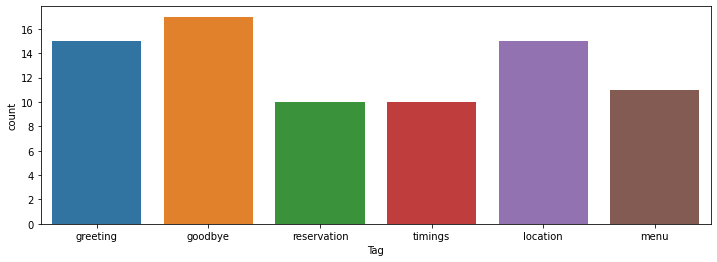

,Tag,Input,Encoded
0,2,can you tell us the location of the restaurants,"[1, 2, 3, 4]"
1,5,restaurant timings please,"[4, 5, 6]"
2,1,hi there,[7]
3,3,types of food available ?,"[8, 9, 10, 11]"
4,0,see you later,"[12, 13]"


In [ ]:
# data preprocessing
tags = []
inputs = []
for intents in contents['intents']:
    for inp in intents['input']:
        tags.append(intents['tag'])
        inputs.append(inp)

# to dataframe
data = pd.DataFrame({
    "Tag":tags,
    "Input":inputs
})

# plotting the count of labels
plt.figure(figsize=(12,4))
sns.countplot(x = data['Tag'])
plt.show()


#shuffling the dataframe
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(['index'],inplace=True,axis=1)

# label encoding the dependent feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Tag'] = le.fit_transform(data['Tag'])

# Encoding Storage
encoding_dict = {
    'words':[],
    'encoding':[]
}

# Encoding Loop for words
ps = PorterStemmer()
for sentence in data['Input']:
    for word in sentence.split(' '):
        word = ps.stem(word.lower())
        if word not in encoding_dict['words'] and word not in stopwords.words('english'):
            encoding_dict['words'].append(word)
            encoding_dict['encoding'].append(len(encoding_dict['words']))


# Encoding the dataframe
encoded_input = []

for i in range(data['Input'].shape[0]):
    row = []
    for word in data['Input'][i].split(' '):
        for j in range(len(encoding_dict['words'])):
            if encoding_dict['words'][j] == ps.stem(word.lower()):
                row.append(encoding_dict['encoding'][j])
    encoded_input.append(row)
data['Encoded'] = encoded_input


#printing the dataframe
data.head()

In [ ]:
# padding
x_list = []
for elem in data['Encoded']:
    x_list.append(elem)

length = 0
for row in x_list:
    if len(row) > length:
        length=len(row)

padded_x = []
for row in x_list:
    for i in range(length - len(row)):
        row.insert(0,0)
    padded_x.append(row)

# converting to pytorch tensors
X = np.array(padded_x)
Y = np.array(data['Tag'])

In [ ]:
print(f"vocabulary size: {X.max()+1}, output targets = {Y.max() + 1}")

vocabulary size: 64, output targets = 6


In [ ]:
# creating the model

# model config
output_targets = Y.max()+1
vocabulary_size = X.max()+1

# neural network
class chatbot(nn.Module):
    def __init__(self,output_targets,vocabulary_size):
        super(chatbot,self).__init__()
        
        # embedding layer
        self.embedding1 = nn.Embedding(vocabulary_size,15)
        
        # lstm
        self.lstm = nn.LSTM(input_size=15,hidden_size=10,batch_first=True,num_layers=1)

        # fully connected
        self.fc1 = nn.Linear(in_features=10,out_features=output_targets)

    def forward(self,x):
        x = self.embedding1(x)
        x,_ = self.lstm(x)
        x = torch.relu(x[:,-1])
        x = self.fc1(x)
        return x

# model
model = chatbot(output_targets=output_targets,vocabulary_size=vocabulary_size)

# parameters
learning_rate = 0.005
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
epochs = 600

# converting to tensors
X = torch.tensor(X,dtype=torch.int64)
Y = torch.tensor(Y,dtype=torch.int64)

In [ ]:
# forward loop
loss = []
acc = []
for i in range(epochs):
    
    # make predictions
    y_pred = model(X)

    # calculate cost
    cost = criterion(y_pred,Y)
    loss.append(cost)

    #calculate accuracy
    accuracy = (y_pred.argmax(axis=1) == Y).sum()/(y_pred.shape[0])
    acc.append(accuracy)

    # backpropogation
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if i%50 == 0:
        print("Epoch: {}\tcost: {:.3f}\tAccuracy:{:.3f}\n".format(i,cost,accuracy))

Epoch: 0	cost: 1.811	Accuracy:0.128

Epoch: 50	cost: 0.950	Accuracy:0.859

Epoch: 100	cost: 0.313	Accuracy:1.000

Epoch: 150	cost: 0.143	Accuracy:1.000

Epoch: 200	cost: 0.077	Accuracy:1.000

Epoch: 250	cost: 0.050	Accuracy:1.000

Epoch: 300	cost: 0.037	Accuracy:1.000

Epoch: 350	cost: 0.028	Accuracy:1.000

Epoch: 400	cost: 0.023	Accuracy:1.000

Epoch: 450	cost: 0.019	Accuracy:1.000

Epoch: 500	cost: 0.016	Accuracy:1.000

Epoch: 550	cost: 0.014	Accuracy:1.000



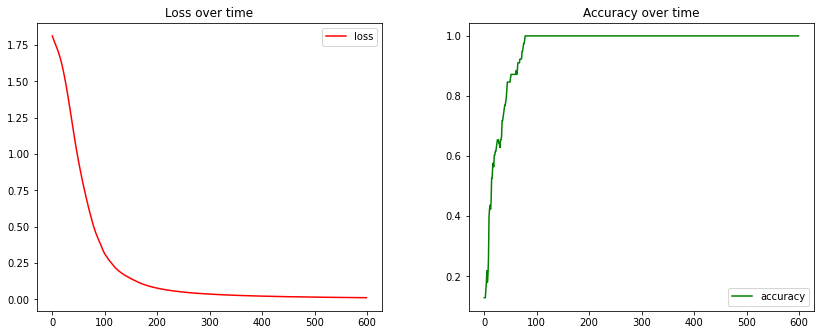

In [ ]:
# loss over time 
fig = plt.figure(figsize=(12,4))

# loss plot
ax1 = fig.add_axes([0,0,0.4,1])
ax1.plot(loss,color='red',label='loss')
plt.title("Loss over time")
plt.legend()

# accuracy plot
ax2 = fig.add_axes([0.5,0,0.4,1])
ax2.plot(acc,color='green',label='accuracy')
plt.legend()
plt.title("Accuracy over time")

# saving the model
torch.save(model.state_dict(),"chatbot.pt")

# saving the encoding dictionary
pickle.dump(encoding_dict,open("encoding_dict.bin","wb"))